In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [17]:
# input
C = 10
L = 2

custom_setup = False
map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [18]:
# define the locations of customers and lockers and warehouse
if custom_setup:
    C_location = np.array([[0.1 ,0.28], [0.2 ,0.4],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],[0.7 ,0.4],[0.9 ,0.5], [0.4, 0.15]])
    W_location = np.array([[0.6 ,0.5]])
    L_location = np.array([[0.3 ,0.5],[0.5,0.2]])
else:
    C_location = np.random.randint(map_size, size=(C, 2))
    W_location = np.random.randint(map_size, size=(1, 2))
    L_location = np.random.randint(map_size, size=(L, 2))
stores_location = np.concatenate((W_location, L_location), axis=0)

In [19]:
def euclidean_distance(location_a, location_b):
    if len(location_a) != 2 or len(location_b) != 2:
        raise Exception("the two location need to be a list each of size 2")
    delta_x = location_b[0]-location_a[0]
    delta_y = location_b[1]-location_a[1]
    return math.sqrt(delta_x*delta_x+delta_y*delta_y)

def find_nearest_stores_from_customer(customer_location, stores_location_par):
    min_distance = float("inf")
    nearest_store_location = []
    index = 0
    nearest_locker_index = -1
    for store_location in stores_location_par:
        distance = euclidean_distance(customer_location, store_location)
        if distance < min_distance:
            min_distance = distance
            nearest_store_location = store_location
            nearest_locker_index = index
        index +=1
    return nearest_locker_index, nearest_store_location


In [20]:
# Customers’ demand and preferences
q = np.ones(C)

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5, 7]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W", "L1"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in range(C):
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores))
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)


In [21]:
# Capacities

# PF vehicles capacities
Q = math.ceil(0.5 * len(C_D))
# locker storage (every locker has the same capacity by default)
W_l = []
for i in range(L):
    W_l.append(math.ceil(0.8 * C / L))
# LF vehicles capacities (every LF vehicle has the same capacity by default)
Q_l = []
for i in range(L):
    Q_l.append(math.ceil(0.6 * W_l[i]))

sum_W_l = 0
for i in range(len(W_l)):
    sum_W_l += W_l[i]


# supply vehicles storage
Q_L = math.ceil(0.8 * sum_W_l)

print("Q: ",Q)
print("W_l: ",W_l)
print("Q_l: ",Q_l)
print("Q_L: ",Q_L)
print("sum_W_l: ", sum_W_l)


Q:  3
W_l:  [4, 4]
Q_l:  [3, 3]
Q_L:  7
sum_W_l:  8


['Cl0', 'Cl1', 'Cl2', 'Cl3']
['Cd0', 'Cd1', 'Cd2', 'Cd3', 'Cd4', 'Cd5']
['Cd0', 'Cd1', 'Cd2', 'Cd3', 'Cd4', 'Cd5', 'Cl0', 'Cl1', 'Cl2', 'Cl3']


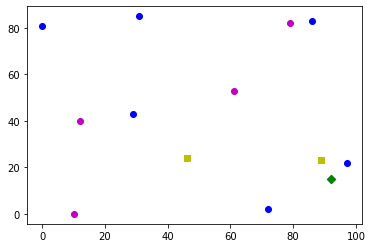

In [22]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])

for i in range(C):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])

CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for i in range(len(C_D)):
    Customers_door.append("Cd"+str(i))
for i in range(len(C_L)):
    Customers_locker.append("Cl"+str(i))

Customers = Customers_door+Customers_locker

print(Customers_locker)
print(Customers_door)
print(Customers)

plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [23]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy = dist_matrix.to_numpy()
print(dist_matrix)

              W         L0          L1         Cd0         Cd1         Cd2  \
W      0.000000  46.872167    8.544004   23.853721    8.602325  113.225439   
L0    46.872167   0.000000   43.011626   34.058773   51.039201   73.246160   
L1     8.544004  43.011626    0.000000   27.018512    8.062258  106.230881   
Cd0   23.853721  34.058773   27.018512    0.000000   32.015621  106.887792   
Cd1    8.602325  51.039201    8.062258   32.015621    0.000000  113.534136   
Cd2  113.225439  73.246160  106.230881  106.887792  113.534136    0.000000   
Cd3   68.264193  71.281134   60.074953   82.200973   61.983869   86.023253   
Cd4   68.942005  25.495098   63.245553   59.413803   71.168813   47.801674   
Cd5   92.849340  62.817195   84.899941   92.574294   91.241438   31.256999   
Cl0   68.249542  66.730802   59.841457   80.305666   62.641839   79.006329   
Cl1   83.360662  43.266615   82.280010   62.032250   89.738509   81.614950   
Cl2   83.815273  37.576588   78.854296   71.021124   86.884981  

In [24]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores,axis=1)
supply_distances_matrix  = supply_distances_matrix.filter(items=stores,axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W']+Customers_door,axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W']+Customers_door,axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door,axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers+Customers_door,axis=0)
print(LF_distances_matrix)

            W         L0         L1
W    0.000000  46.872167   8.544004
L0  46.872167   0.000000  43.011626
L1   8.544004  43.011626   0.000000
              W         Cd0         Cd1         Cd2        Cd3        Cd4  \
W      0.000000   23.853721    8.602325  113.225439  68.264193  68.942005   
Cd0   23.853721    0.000000   32.015621  106.887792  82.200973  59.413803   
Cd1    8.602325   32.015621    0.000000  113.534136  61.983869  71.168813   
Cd2  113.225439  106.887792  113.534136    0.000000  86.023253  47.801674   
Cd3   68.264193   82.200973   61.983869   86.023253   0.000000  69.634761   
Cd4   68.942005   59.413803   71.168813   47.801674  69.634761   0.000000   
Cd5   92.849340   92.574294   91.241438   31.256999  55.036352  42.047592   

           Cd5  
W    92.849340  
Cd0  92.574294  
Cd1  91.241438  
Cd2  31.256999  
Cd3  55.036352  
Cd4  42.047592  
Cd5   0.000000  
            L0          L1         Cd0         Cd1         Cd2        Cd3  \
L0    0.000000   43.011626

In [26]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

            W         L0         L1
W    0.000000  35.154125   6.408003
L0  35.154125   0.000000  32.258720
L1   6.408003  32.258720   0.000000
              W         Cd0         Cd1         Cd2        Cd3        Cd4  \
W      0.000000   23.853721    8.602325  113.225439  68.264193  68.942005   
Cd0   23.853721    0.000000   32.015621  106.887792  82.200973  59.413803   
Cd1    8.602325   32.015621    0.000000  113.534136  61.983869  71.168813   
Cd2  113.225439  106.887792  113.534136    0.000000  86.023253  47.801674   
Cd3   68.264193   82.200973   61.983869   86.023253   0.000000  69.634761   
Cd4   68.942005   59.413803   71.168813   47.801674  69.634761   0.000000   
Cd5   92.849340   92.574294   91.241438   31.256999  55.036352  42.047592   

           Cd5  
W    92.849340  
Cd0  92.574294  
Cd1  91.241438  
Cd2  31.256999  
Cd3  55.036352  
Cd4  42.047592  
Cd5   0.000000  
            L0         L1        Cd0        Cd1        Cd2        Cd3  \
L0    0.000000  36.559882  28.

## extra code to delete

In [ ]:
x = np.random.randint(0, 50, 7)
y = np.random.randint(0, 50, 7)
C = [x,y]
plt.scatter(C[0],C[1])
C = np.arange(7)
print(C)
plt.show()

In [ ]:
C = np.random.rand(7,2)
plt.scatter(C[:,0],C[:,1],color='b')
W = np.random.rand(1,2)
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.random.rand(1,2)
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')
print(C)

In [ ]:
C = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
              [0.9 ,0.5],[0.7 ,0.3]])
plt.scatter(C[:,0],C[:,1],color='b')
W = np.array([[0.6 ,0.5]])
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.array([[0.3 ,0.5]])
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')

In [ ]:
#calcolo la matrice delle distanze:
data = np.array([])
data = np.append(data,W)
data = np.vstack([data,L])
data = np.vstack([data,C])
buildings =['Warehouse','Locker','c1','c2','c3','c4','c5','c6','c7']
print(len(data))
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()

In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [30]:
print("andrea")


andrea


In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy
